In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import os 
import glob 
import pandas as pd
import medpy.io
from utils import plot_comparison 
%matplotlib inline

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---

# Training and Validation Data

In [2]:
#path 
storage_path = "/home/kevinteng/Desktop/ssd02/"
#original 
training_ds_path = storage_path+"MICCAI_BraTS2020_TrainingData/"
validation_ds_path = storage_path+"MICCAI_BraTS2020_ValidationData/"
#preprocessed
training_pre = storage_path+"BraTS2020_preprocessed/Training_pre/"
validation_pre = storage_path+"BraTS2020_preprocessed/Validation_pre/"

In [3]:
def create_data(input_path, output_path, min_max_norm = False, validation = False, swapaxes = False, verbose=True):
    if validation==False:
        csv_path = glob.glob(input_path+"name_mapping*.csv")
        csv_file = pd.read_csv(csv_path[0])
        grade = np.array(csv_file["Grade"].tolist()) #csv list with HGG or LGG
        #index grade type from csv
        grade_type = np.unique(grade) #class: HGG or LGG
        img_type = ['flair', 'seg','t1', 't1ce','t2']
        #create folder for HGG and LGG
        for types in grade_type:
            save_path_01 = output_path+"/"+types
            if not os.path.exists(save_path_01):
                os.makedirs(save_path_01)
            #create folder for img_type inside HGG or LGG folder
            for imgs in img_type:
                save_path_02 = save_path_01+"/"+imgs
                if not os.path.exists(save_path_02):
                    os.makedirs(save_path_02)
    #create directory to store validation data 
    else: #validation == True
        if not os.path.exists(output_path):
            os.makedirs(output_path)
    HGG_count = 0
    LGG_count = 0
    val_count = 0
    for indx, patient in enumerate(sorted(os.listdir(input_path))):
        #ex:/home/kevinteng/Desktop/ssd02/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/
        input_path01 = os.path.join(input_path+patient+"/")
        #for training data
        if not patient.endswith('.csv') and validation==False: #do not need to read .csv files
            #direct path to either HGG or LGG w.r.t patients
            if grade[indx]=='HGG':
                output_path01 = os.path.join(output_path+"/HGG/")
                HGG_count+=1 #increment for HGG 
            else:
                output_path01 = os.path.join(output_path+"/LGG/")
                LGG_count+=1 #increment for LGG
        #for validation data
        elif not patient.endswith('.csv') and validation!=False:
            output_path01 = output_path
            val_count+=1
        else: #skip csv file
            continue
        for patient_imgs in sorted(os.listdir(input_path01)):
            #'BraTS20_Training_001_flair.nii.gz'
            img = patient_imgs.split('.')[0].split('_')[-1]
            #direct save path to corresponding image types (flair,seg,t1,t1ce,t2)
            if img =='flair':
                output_path02 = os.path.join(output_path01+"/flair/")
            elif img =='seg':
                output_path02 = os.path.join(output_path01+"/seg/")
            elif img == 't1':
                output_path02 = os.path.join(output_path01+"/t1/")
            elif img == 't1ce':
                output_path02 = os.path.join(output_path01+"/t1ce/")
            else: #t2
                output_path02 = os.path.join(output_path01+"/t2/")
            if not os.path.exists(output_path02):
                os.makedirs(output_path02)
            #read imgs
            input_path02 = os.path.join(input_path01+patient_imgs)
            read_med_img,_ = medpy.io.load(input_path02)
            img_slices = read_med_img.shape[-1] #last channel is image slices
            #min max normalization switch, label 'seg' not included
            if img!= 'seg' and min_max_norm==True:
                norm_list = []
                for i in range(read_med_img.shape[-1]): #last channel is the slices 
                    max_val = np.max(read_med_img[:,:,i]) #max value in that slice
                    min_val = np.min(read_med_img[:,:,i]) #min value of that slice
                    norm = (read_med_img[:,:,i] - min_val)/(max_val-min_val)
                    norm_list.append(norm)
                read_med_img = np.array(norm_list) #=>(155, 240, 240)
                read_med_img = np.nan_to_num(read_med_img)
                if swapaxes==True: #=>(240, 240, 155) in case of 3D 
                    read_med_img = np.swapaxes(read_med_img, 0,1)
                    read_med_img = np.swapaxes(read_med_img, 1,2)
            save = np.save(output_path02+"/{}_{}.npy".format(patient,img), read_med_img)
    #output info after preprocessing
    if verbose:
        print("Medical image dimensions:{}".format(read_med_img.shape))
        if not validation:
            print("HGG patients: {}".format(HGG_count))
            print("LGG patients: {}".format(LGG_count))
            print("Total patients: {}".format(HGG_count + LGG_count))
            print("Total image slices: {}".format((HGG_count + LGG_count)*img_slices))
        else:
            print("Total patients: {}".format(val_count))
            print("Total image slices: {}".format(val_count*img_slices))

In [4]:
# #preprocessed training data
create_data(training_ds_path, training_pre, min_max_norm = True, swapaxes = True)

/home/kevinteng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide


Medical image dimensions:(240, 240, 155)
HGG patients: 293
LGG patients: 76
Total patients: 369
Total image slices: 57195


In [5]:
#preprocessed validation data
create_data(validation_ds_path, validation_pre, min_max_norm = True, validation = True, swapaxes = True)

/home/kevinteng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide


Medical image dimensions:(240, 240, 155)
Total patients: 125
Total image slices: 19375


---

# Labels (Optional)

In [62]:
def split_labels(inp_path, out_path):
    for lbls in sorted(os.listdir(inp_path)):
        patient_tag = lbls.split('.')[0]
        npy_path = os.path.join(inp_path+'/'+lbls)
        labels = np.load(npy_path)
        #labels path
        core_path = out_path+'core/'
        enhancing_tumor_path = out_path+'enhancing_tumor/'
        complete_tumor_path = out_path+'complete_tumor/'

        #core, label 1,4
        if not os.path.exists(core_path):
            os.makedirs(core_path)
        core = np.where(((labels==1) | (labels==4)), labels, 0)
        np.save(core_path+'core_{}.npy'.format(patient_tag), core)
        #enhancing tumor, label 4
        if not os.path.exists(enhancing_tumor_path):
            os.makedirs(enhancing_tumor_path)
        enhancing_tumor = np.where(labels==4, labels, 0)
        np.save(enhancing_tumor_path+'enhancing_tumor_{}.npy'.format(patient_tag), enhancing_tumor)

        #complete tumor all label 1,2,3,4
        if not os.path.exists(complete_tumor_path):
            os.makedirs(complete_tumor_path)
        complete_tumor = np.where(labels>=0, labels, 0 )
        np.save(complete_tumor_path+'complete_tumor_{}.npy'.format(patient_tag), complete_tumor)
    

In [16]:
training_hgg_label = storage_path+"BraTS2020_preprocessed/Training_pre/HGG/seg"
training_lgg_label = storage_path+"BraTS2020_preprocessed/Training_pre/LGG/seg"
desktop_hgg_path = storage_path+'BRAT20_lbl/HGG/'
desktop_lgg_path = storage_path+'BRAT20_lbl/LGG/'

In [63]:
split_labels(training_hgg_label, desktop_hgg_path)
split_labels(training_lgg_label, desktop_lgg_path)

---

# Sanity Check

In [64]:
#check label 
#HGG
lbl_count = 3
seg_list = []
for lbls in sorted(os.listdir(desktop_hgg_path)):
    merge_00 = os.path.join(desktop_hgg_path+lbls+"/")
    for seg in sorted(os.listdir(merge_00)):
        print(seg)
        segmentation = np.load(merge_00+seg)
        break
    seg_list.append(segmentation)
    lbl_count+=1
    if lbl_count == 3:
        break

complete_tumor_BraTS20_Training_001_seg.npy
core_BraTS20_Training_001_seg.npy
enhancing_tumor_BraTS20_Training_001_seg.npy


In [77]:
tst = np.load('/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed/Training_pre/HGG/seg/BraTS20_Training_001_seg.npy')
print(np.unique(tst)) #only 4 labels

[0 1 2 4]


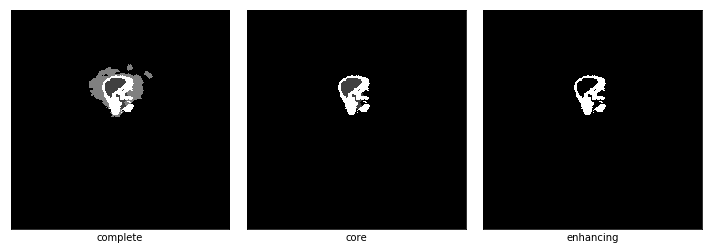

In [69]:
input_img = [seg_list[i][:,:,50] for i in range(len(seg_list))]
caption = ['complete', 'core', 'enhancing']
plot_comparison(input_img, caption, n_col = 3, figsize=(10,10))

In [42]:
img_count = 0
multimodal_list = []
for imgs in sorted(os.listdir(training_pre+"HGG/")):
    if imgs!='seg':
        merge_00 = os.path.join(training_pre+"HGG/"+imgs+"/")
        for mm in sorted(os.listdir(merge_00)):
            print(mm)
            multimodal = np.load(merge_00+mm)
            break
        multimodal_list.append(multimodal)
        img_count+=1
    if img_count==4:
        break

BraTS20_Training_001_flair.npy
BraTS20_Training_001_t1.npy
BraTS20_Training_001_t1ce.npy
BraTS20_Training_001_t2.npy


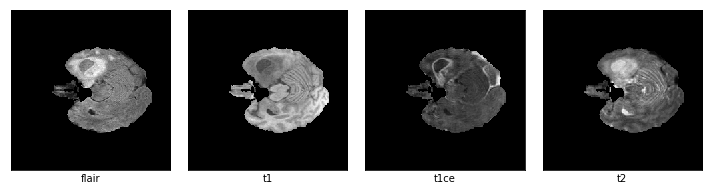

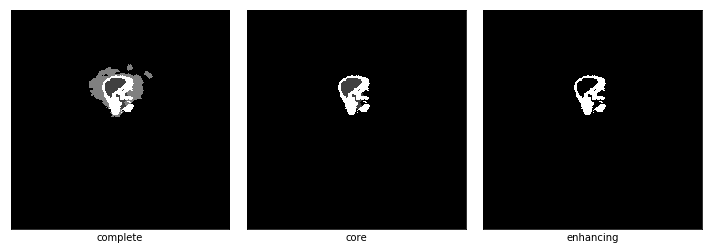

In [70]:
input_img = [multimodal_list[i][50,:,:] for i in range(len(multimodal_list))]
caption = ['flair', 't1', 't1ce', 't2']
plot_comparison(input_img, caption, n_col = len(input_img), figsize=(10,10))

input_img02 = [seg_list[i][:,:,50] for i in range(len(seg_list))]
caption02 = ['complete', 'core', 'enhancing']
plot_comparison(input_img02, caption02, n_col = 3, figsize=(10,10))

---

# Stacking Images 

In [2]:
def threeD_to_twoD(save_dir, input_path):
    '''
    Stack all the images according to slices of a patient to create a 2D image stacks
    
    @param save_dir: The directory where the images need to be save
    @param input_path: The path where pre-processed .npy file is stored 
    '''
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for brain_tumour in sorted(os.listdir(input_path)): #HGG/LGG
        #create folder for HGG or LGG
        #only for Training folder since HGG/LGG are not available
        #for validation dataset
        save_path01 = save_dir + brain_tumour
        if not os.path.exists(save_path01):
            os.makedirs(save_path01)
        merge_path_00 = os.path.join(input_path+brain_tumour+"/")
        for multi_modal in sorted(os.listdir(merge_path_00)): #flair,t1,t1ce,t2,seg
            #create folder for multi modals
#             save_path02 = save_path01 + "/"+multi_modal
#             if not os.path.exists(save_path02):
#                 os.makedirs(save_path02)
            merge_path_01 = os.path.join(merge_path_00+multi_modal+'/')
            img_stack = []
            for patient in sorted(os.listdir(merge_path_01)): #patient.npy
                merge_path_02 = os.path.join(merge_path_01+patient)
                med_img = np.load(merge_path_02).astype(np.float32) #channel front
                for i in range(med_img.shape[-1]): #last dimension is the number of slices
                    img_stack.append(med_img[:,:,i])
            img_stack = np.array(img_stack)
            np.save(save_path01+'/{}_stack.npy'.format(multi_modal), img_stack)

In [3]:
save_dir = "/home/kevinteng/Desktop/ssd02/BraTS2020_stack/"
input_path = "/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed/Training_pre/"

threeD_to_twoD(save_dir, input_path)

---

# Data Serialization with TF_Records (for fast loading)

In [3]:
def concat_recursive(a, b, max_count,count=0):
    '''
    Recursively concatenate the image stacks with the next image stacks
    
    @param a: Top first image stacks
    @param b: Following image stacks
    '''
    while count<max_count-1: 
        c = np.concatenate((a,b), axis = 0)
        a = c
        count+=1
        concat_recursive(a,b, max_count, count)
    return a

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    # If the value is an eager tensor BytesList won't unpack a string from an EagerTensor.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() 
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(image, label):
    '''
    Adding image and label info to TFRecords dataset
    '''
    feature = {
        'image': _bytes_feature(image),
        'label': _bytes_feature(label),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def write_tfrecords(tfrecord_dir, image_paths, labels_path):
    '''
    write TFRecords to appointed directory 
    '''
    with tf.io.TFRecordWriter(tfrecord_dir) as writer:
        for image, label in zip(image_paths, labels_path):
            img_bytes = tf.io.serialize_tensor(image)
            labels = tf.io.serialize_tensor(label)
            example = serialize_example(img_bytes, labels)
            writer.write(example)
            
def read_tfrecord(serialized_example):
    '''
    read TFRecords from appointed directory 
    '''
    feature_description = {
        'image': tf.io.FixedLenFeature((), tf.string),
        'label': tf.io.FixedLenFeature((), tf.string),
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    
    image = tf.io.parse_tensor(example['image'], out_type = float)
    label = tf.io.parse_tensor(example['label'], out_type = float)
    
    return image, label

def parse_tfrecord(tf_dir):
    tfrecord_dataset = tf.data.TFRecordDataset(tf_dir)
    parsed_dataset = tfrecord_dataset.map(read_tfrecord)
    return parsed_dataset

In [3]:
tfrecord_folder = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords/'
save_dir = "/home/kevinteng/Desktop/ssd02/BraTS2020_stack/"
#zip stack images with labels
for brain_tumour in sorted(os.listdir(save_dir)): #HGG/LGG
    print(brain_tumour)
    merge_path_00 = os.path.join(save_dir+brain_tumour+"/")
    #create HGG/LGG folders for tf_records
    save_path00 = tfrecord_folder + brain_tumour
    if not os.path.exists(save_path00):
        os.makedirs(save_path00)
    ground_truth = np.load(merge_path_00+'seg_stack.npy') 
    for multimodals in sorted(os.listdir(merge_path_00)): #t1,t1ce,flair,t2,seg
        print("-->",multimodals)
        merge_path_01 = os.path.join(merge_path_00+multimodals)
        if multimodals=='seg_stack.npy':
            #skip labels
            continue
        foreground = 0 #to declutter RAM
        foreground = np.load(merge_path_01)
        save_name = multimodals.split(".")[0]
        tfrecord_dir = save_path00 + save_name +'.tfrecords'
        write_tfrecords(tfrecord_dir, foreground,ground_truth)



HGG
--> flair_stack.npy
--> seg_stack.npy
--> t1_stack.npy
--> t1ce_stack.npy
--> t2_stack.npy
LGG
--> flair_stack.npy
--> seg_stack.npy
--> t1_stack.npy
--> t1ce_stack.npy
--> t2_stack.npy


In [8]:
#sanity check
tfrecords_read_dir = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords/HGG/'
SHUFFLE_BUFFER = 4000
BATCH_SIZE = 8

for tf_re in sorted(os.listdir(tfrecords_read_dir)):
    tf_dir = os.path.join(tfrecords_read_dir+tf_re)
    dataset = parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
    image, label = next(iter(dataset))
    image = tf.reshape(image, [-1, 240, 240, 1])
    label = tf.reshape(label, [-1, 240, 240, 1])
    break

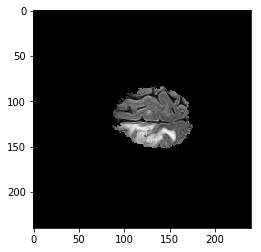

In [9]:
plt.imshow(tf.squeeze(image[2]), cmap = 'gray')

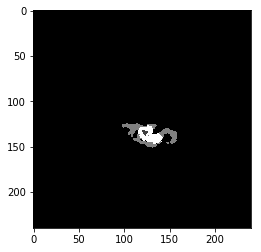

In [10]:
plt.imshow(tf.squeeze(label[2]), cmap = 'gray')